# QuantLET Example: Backtesting Momentum Strategies using Streams and Monte Carlo Simulations

http://quantlet.net

This example shows the use of streams and benchmarks for the backtesting of profitability of momentum strategies. The focus here is to showing QuantLET patterns and how they can be used as tools for investigation in computational finance. 

The data investigation methods shown here are simplified so this not be the best place to come if you just want learn how to use computers to make money in financial markets.

(c) 2015 Jorge M. Faleiro Jr


First things first, initial setup of defaults

In [1]:
%pylab inline 
%load_ext autoreload 
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


Importing initial set of quantlet dependencies.

NB: We will use the `%time` magic throughout some of these examples to give a sense of performance of specific feature of the framework. Look for 'wall time' just below a cell, this has been generated in an Ubuntu guest environment in Parallels hosted by a MacBook Pro (Retina, 13-inch, Late 2012).

In [2]:
import quantlet as q
from quantlet.rw import brownian
from quantlet_analytics.plot import plot
from quantlet_analytics.time import ts
#q.figsize(15, 14) # uncomment to change default figure sizes
#q.figsize(13, 10)

interactive mode


## Random Walks

The first principle we will need on this model are random walks. In essence a random walk is a path composed of several intermediary random steps. 

On this example we will use specifically a simplification of a one-dimensional Wiener Process, or Brownian Motion, defined by the following model:

\begin{align}
W_0 & = 0 \\
W_t & \sim N(0, t -s) + W_s \\
\end{align}

where $t \rightarrow W_t$ is continuous, $N(\mu, \sigma^2)$ is the normal distribution with expected value $\mu$ and variance $\sigma^2$ and for any $\text{t, s and u}$, $W_t - W_s$ are independent for $u \le s \lt t$.

In QuantLET, we define brownian motions with a `brownian` QLet. To generate a plot of a simulation of closing prices starting with an initial price of $37 for 2013 we use one stream, defined in one line:

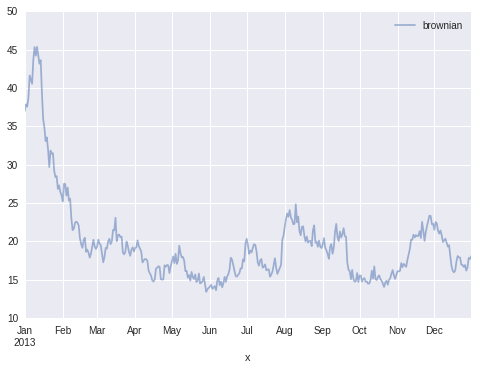

In [3]:
ts('2013-01-01', '2013-12-31') >> brownian(seed=42, s0=37) >> plot

Another example, if you want a simulation of three stock prices - GOOG, IBM and B, with initial prices of $37, $21 and $42 respectivelly - we use one stream of three individual QLets:

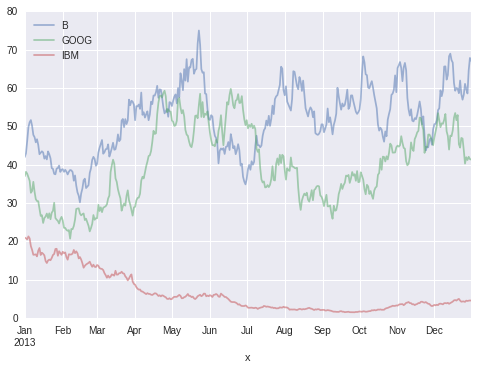

In [4]:
q.seed(42)
ts('2013-01-01', '2013-12-31') \
>> brownian(s0=37, output='GOOG') \
>> brownian(s0=21, output='IBM') \
>> brownian(s0=42, output='B') \
>> plot

## Moving Averages

The second principle we will need on this experiment are some kind of filter, against which we will compare cross over variations of the random walk in order to generate buy and sell signals.

We will be experimenting with Cumulative, Rolling, Weighted and Exponentially weighted moving averages, listed in increasing order of complexity. 

We provide the mathematical formalization of each of the filters. For computational reasons QuantLET models are encouraged to rely on filters on their recursive form. We also provide the non-recursive form for illustration purposes.

### Cumulative Moving Average
The cumulative average is a simple average of $n$ values:

\begin{align}
CMA_n & = \frac{1}{n} \sum_{i=0}^n x_i,\quad\quad\quad\quad & \text{non-recursive form}\\
CMA_n & = \frac{x_n + (n - 1) * CMA_{n-1}}{n},\quad\quad & \text{recursive form} 
\end{align}

### Rolling Moving Average
The "rolling" average of $n$ values over a window of fixed size $m$:

\begin{align}
RMA_n & = \frac{1}{m} \sum_{i=n-m+1}^n x_i,\quad\quad\quad\quad & \text{non-recursive form}\\
RMA_n & = RMA_{n-1} + \frac{1}{m} (x_n - x_{n-m+1}),\quad\quad & \text{recursive form} 
\end{align}


### Weighted Moving Average
In the weighted moving average $m$ past factors are adjusted by a decreasing linear factor $(m - n + i)$ and its non-recursive form is given by:

\begin{align}
WMA_n & = \frac{2}{m(m+1)} \sum_{i=n-m+1}^n (m - n + i)x_i\\
\end{align}

### Exponentially Weighted Moving Average
In the exponentially moving average a factor $\alpha$ is used to decay older terms of the series and its recursive form is given by:

\begin{align}
EWMA_n & = \alpha . x_n + (1 - \alpha) . EWMA_{n-1}\\
\end{align}

The higher $\alpha$ the more older terms will influence the filter. A lower $\alpha$ means a "faster" filter.

In [5]:
from quantlet.filter import rma, cma, ewma

A bit of an unrealistic use case, for illustration, you can overlap several filters - EWMA, RMA, CMA - with a random walk of initial price $37 for the year 2014 using a one liner stream. 

You can refer to the mathematical formalizations above if you want details on each of the parameters.

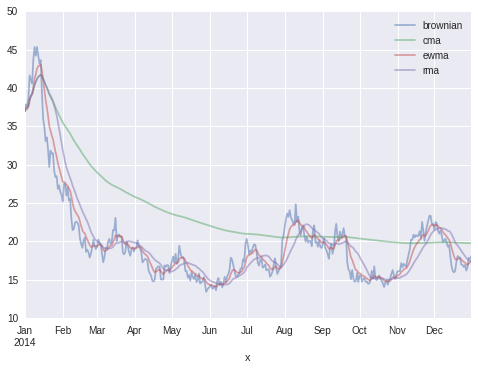

In [6]:
ts('2014-1-1', '2014-12-31') \
>> brownian(seed=42, s0=37) \
>> ewma(alpha=0.2) \
>> rma(m=20) \
>> cma \
>> plot

In [7]:
from quantlet.strats.momentum import maco
from quantlet.strats.portfolio import cash_stock

The third and fourth principle of this experiment are strategies to generate buy/sell signals and real-time portfolio management. We add them to the original stream as processors`maco` and `cash_stock`, in a daily timeseries for 2013 and 2014, of a random walk starting at $37. This model is of course a simplification and should not be used on real world trading.

The `maco` momentum strategy generates a buy or sell signal for cross overs. It is indicated on the plot by green and red triangles.

The `cash_stock` portfolio strategy keeps track of overall gains or losses of those buy/sell signals and cash available for trading. The configuration below uses an initial `$10,000` cash balance for trading and a load (transaction cost) of `$7.5` per transaction.

This is still a one liner stream. Line termination characters of '\' are used to increase readability.

CPU times: user 208 ms, sys: 0 ns, total: 208 ms
Wall time: 347 ms


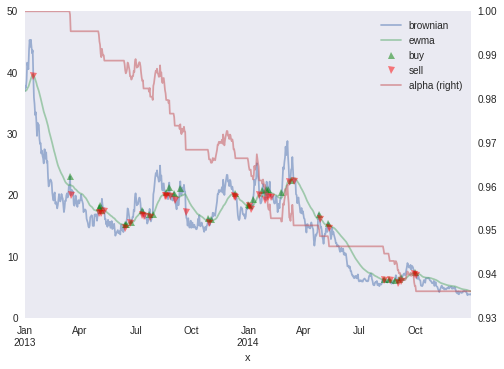

In [8]:
%time ts('2013-1-1', '2014-12-31') \
>> brownian(seed=42, s0=37) \
>> ewma(alpha=0.05) \
>> maco \
>> cash_stock(initial_cash=10000, load=7.5) \
>> plot(columns=['brownian', 'ewma', 'buy', 'sell', 'alpha']) # ordering
# >> plot # uncomment if you don't care about label ordering 

A few things we can quickly notice about our great strategy from the plot above:

1. It is fast. A few hundred microseconds to timestamp, randomize, signal and track.

2. It is losing money. At this first shot, this strategy is not profitable. Just take a look at alpha, the pinkish line shooting down. In this simple example, you should expect to lose ~6.5% over 2 years if you were to use a moving average cross over trading strategy 

So the immediate questions that jump to our minds: are MACO strategy money losers? Are they never profitable? What do we need to fine tune in order to select scenarions under which they might be profitable?

Let's start to make a few assumptions:

1. There are scenarios under which MACO strategies are profitable.

2. For some combinations of EWMA's alpha, brownian's S0 and cash_stock's load, we should expect the cross-over strategy to become profitable.

Those assumptions are our hypothesis. Alpha, S0 and load are our independent variables and profitability is our dependent variable.

The following model (with a boring name `my_model`) defines our hypothesys and features under consideration.

In [9]:
def my_model(shock):
    stream = ts('2013-1-1', '2014-12-31') \
    >> brownian(s0=shock.s0) \
    >> ewma(alpha=shock.alpha) \
    >> maco \
    >> cash_stock(initial_cash=10000, load=shock.load) \
    >> tail(1) \
    >> as_type(tuple) 
    shock.last_alpha = stream[0]['alpha']


In [10]:
from quantlet import tail, select, as_type, columns
from quantlet_agents import montecarlo
from quantlet_analytics.stats import unif

## Uniform Distributions

If $rs(n)$ is a random sample, the continuous uniform distribution $Unif[a,b), b > a$ of size $n$ is given by $(b - a) * rs(n) + a$:

In [11]:
q.seed(42)
%time \
b = montecarlo(my_model, \
                    s0=unif(5.0, 10.0, 3),\
                    alpha=unif(0.01, 0.8, 5),\
                    load=unif(1.0, 3.0, 3)) \
>> select(lambda x: x.__dict__) \
>> select(lambda x: dict(fitness=x['last_alpha'],dampening=x['alpha'],s0=x['s0'],load=x['load'])) \
>> as_type(tuple)

CPU times: user 1.08 s, sys: 8 ms, total: 1.09 s
Wall time: 1.21 s


In [12]:
print('shocks: %d' % len(b))

shocks: 45


In [13]:
from quantlet_analytics.plot import lag_plot, scatter_matrix

CPU times: user 7.96 s, sys: 1.49 s, total: 9.44 s
Wall time: 15.9 s


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


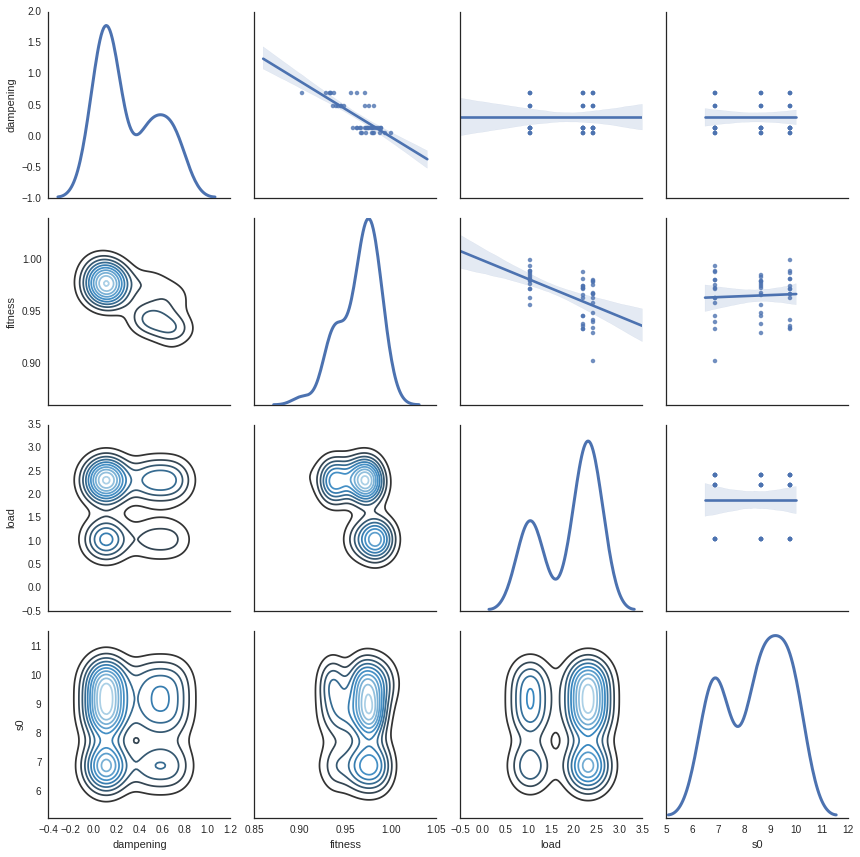

In [14]:
%time b >> scatter_matrix(index=None)

We can quickly see that our first simulation brings a few conclusions:

1. Regardless of what we simulate we cannot get fitness above 1.0 (our own definition of "profitable").
2. The lower $EWMA(\alpha)$, dampening, more chances of making money (higher fitness)
2. The lower the transaction costs, $load$, more chances of making money (no kidding)
2. Some features, specifically $S_0$ has almost no impact on fitness.

We will show how easy is to modify a model. Let's remove $S_0$ and add Brownian's $\sigma$.

CPU times: user 4.46 s, sys: 292 ms, total: 4.76 s
Wall time: 8.28 s
CPU times: user 7.99 s, sys: 380 ms, total: 8.37 s
Wall time: 11.8 s


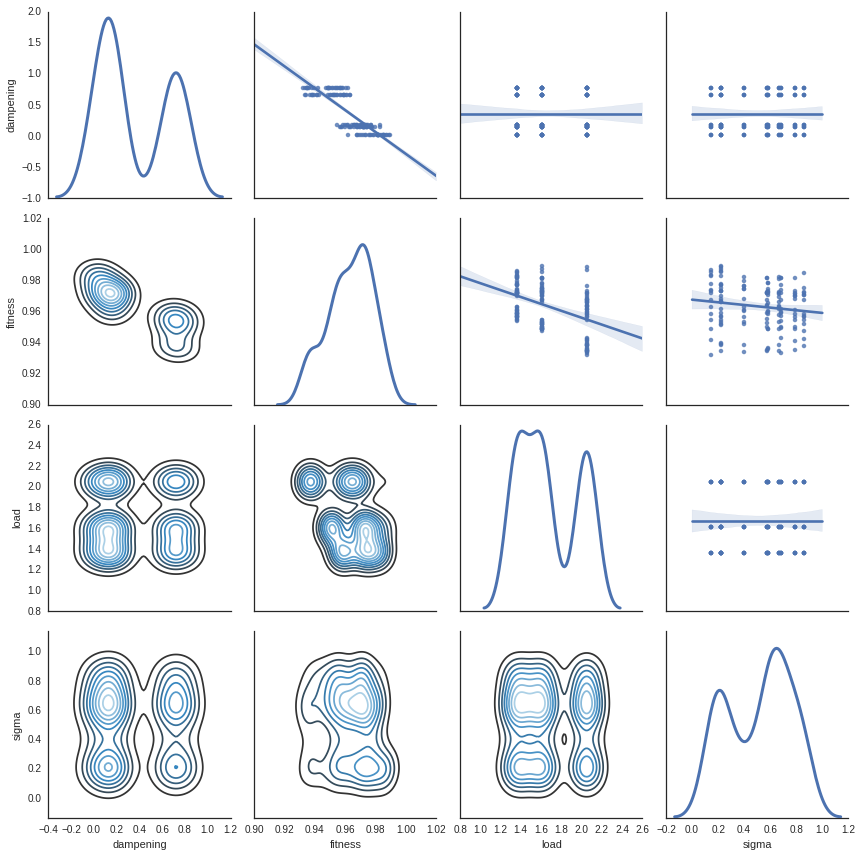

In [15]:
def my_model_modified(shock):
    stream = ts('2013-1-1', '2014-12-31') \
    >> brownian(sigma=shock.sigma) \
    >> ewma(alpha=shock.alpha) \
    >> maco \
    >> cash_stock(initial_cash=10000, load=shock.load) \
    >> tail(1) \
    >> as_type(tuple) 
    shock.last_alpha = stream[0]['alpha']
    
q.seed(42)
%time \
b = montecarlo(my_model_modified, \
                    sigma=unif(0.1, 0.9, 10),\
                    alpha=unif(0.01, 0.8, 5),\
                    load=unif(1.0, 3.0, 3)) \
>> select(lambda x: x.__dict__) \
>> select(lambda x: dict(fitness=x['last_alpha'],dampening=x['alpha'],sigma=x['sigma'],load=x['load'])) \
>> as_type(tuple)
%time b >> scatter_matrix(index=None)

Our second simulation brings a few new conclusions:

1. It is very simple to add and remove features (we removed $S_0$ and added $\sigma$ with a few characters change)
1. We still cannot get to make this strategy profitable (fitness < 0)
1. Lower volatility $\sigma$ causes this strategy to lose a bit less money

In other words, the hypothesis we had outline on the beginning of this exercise cannot hold against a random walk signal. Could it hold in a backtest against historical asset prices? 

## Backtesting Against Constituents of the S&P 500 Index

By now we would like to know if this same strategy would be profitable if applied against asset price movements. In other words, would this strategy be profitable if applied against stocks that are part of the S&P 500 index? 

In [16]:
from quantlet_analytics.dataset import historical
from quantlet.metadata import provenance

Like any other contributions, historical prices are evidences, and available for application in any model. 

As an example, if you wanted to plot the adjusted close price of Apple Computers for the year 2014, you use one line:

CPU times: user 128 ms, sys: 56 ms, total: 184 ms
Wall time: 564 ms


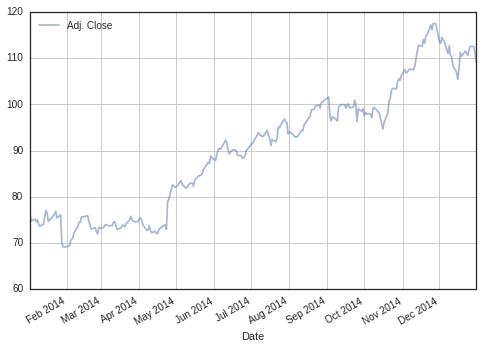

In [17]:
%time \
historical('AAPL', '2014-01-01', '2014-12-31', columns=['Adj. Close']) \
>> plot(index='Date')

If you wanted to appy the momentum strategy model, we replace the 2 steps time series `ts` and random walk `brownian` by one line: `historical`.

You can notice that apart from this simple modification, the model is exactly the same as defined by the random walk example previously. This shows how quick and simple it is to modify a feature of the investigation entirely.

The parameters of `historical` indicate the symbol in question `AAPL`, the date range, and the specific feature `"Adj. Close"`, the split adjusted closing price:

CPU times: user 172 ms, sys: 24 ms, total: 196 ms
Wall time: 405 ms


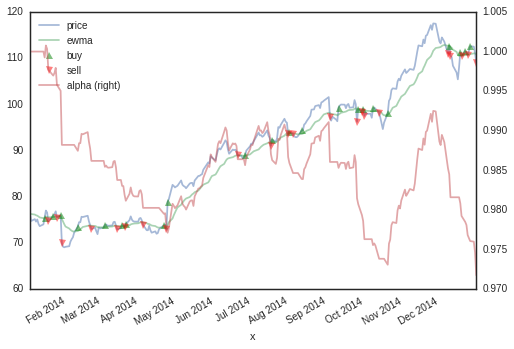

In [18]:
%time \
historical('AAPL', '2014-01-01', '2014-12-31', columns=['Adj. Close']) \
>> select(lambda x : dict(x=x['Date'],price=x['Adj. Close'])) \
>> ewma \
>> maco \
>> cash_stock(initial_cash=10000, load=7.5) \
>> plot(columns=['price', 'ewma', 'buy', 'sell', 'alpha'])

The original scenario repeats itself here. You can see once more, with real data, if one were to apply this momentum strategy in a portfolio of one stock, Apple Computers, one should expect a loss of about 3% during 2014.

In other words, the strategy is still a money loser. The initial investment of `$10,000` on 1/1/2014 would turn into something close to `$9,700` by 12/31/2014.

Is this something specific to Apple Computers? What it we try the same thing with some other stock like Google? To try that, all we have to do is to change the symbol from `AAPL` to `GOOG`.

For illustration we will create a contribution of a plot and will name if `'goog_momentum.png'` 

CPU times: user 212 ms, sys: 140 ms, total: 352 ms
Wall time: 1.27 s


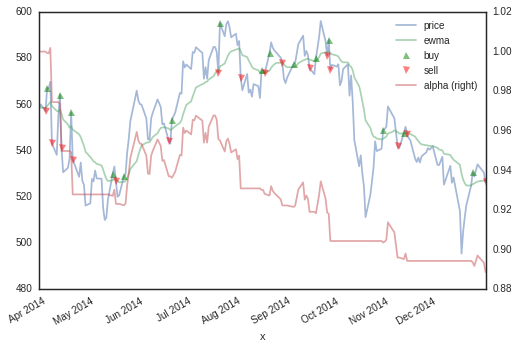

In [19]:
%time \
historical('GOOG', '2014-01-01', '2014-12-31', columns=['Adj. Close']) \
>> select(lambda x : dict(x=x['Date'],price=x['Adj. Close'])) \
>> ewma \
>> maco \
>> cash_stock(initial_cash=10000, load=7.5) \
>> plot(out='goog_momentum.png', columns=['price', 'ewma', 'buy', 'sell', 'alpha'])

With Google we lost even more, about `12%`. Of the original investiment of `$10,000` on 1/1/2014 you would have `$8,800` left by 12/31/2014.

As a side note, plots are also contributions (or evidences). And as any evidences they carry a record of provenance:

In [20]:
provenance('goog_momentum.png')


**** PROVENANCE hdf://quantlet/jfaleiro/goog_momentum.png ****

quandl.get('https://www.quandl.com/data/WIKI/GOOG')
`-- v N/A jfaleiro @ 8/15/2015 14:35:12 EST

historical.cache('hdf://quantlet/pub/quandl/WIKI/GOOG.h5')
`-- v 0.0.1 jfaleiro @ 8/15/2015 14:35:12 EST MD5:d9d914b9bdcd9fccd913d4ab77909dbf

stream('hdf://quantlet/jfaleiro/stream/local-xFybofl')
historical('GOOG', '2014-01-01', '2014-12-31', columns=['Adj. Close']) 
>> select(lambda x : dict(x=x['Date'],price=x['Adj. Close'])) 
>> ewma 
>> maco 
>> cash_stock(initial_cash=10000, load=7.5)
>> plot(out='goog_momentum.png', columns=['price', 'ewma', 'buy', 'sell', 'alpha']))
`-- v 0.0.1 jfaleiro @ 9/1/2015 8:15:35 EST

file('hdf://quantlet/jfaleiro/goog_momentum.png')
`-- v N/A jfaleiro @ 9/17/2015 21:05:02 EST MD5:72802afc4283d8077da1cb368aa6c2cd

**** end of hdf://quantlet/jfaleiro/goog_momentum.png ****
        


There are several things we can notice from this record:

1. The source and steps for generation is public and transparent.
1. The contribution is associated to an URL, `hdf://quantlet/jfaleiro/goog_momentum.png`, and can be shared with any user with proper credentials.
1. The data used to create the plot was obtained from quandl on 8/15/2015 at 14:35:12 EST and passed through several other stages (themselves contributions) for caching and transformation, up until its generation on 9/17/2015 at 21:05:02 EST
1. All contributions are signed and checksum'ed 

Ending this side note, and back to the exercise at hand. Still, these are only 2 stocks, on the same sector. This performance could be related to some bias.

The final proof, let's backtest this against all stocks constituent of the index S&P 500. That should be representative of a mix of sectors and different caps.

The first thing to desing when coming up with a benchmark is the definition of a model. Let's call this model `snp500_model`. You can see it is 99% the same as the benchmark we used on the random walk case, except that now only two features are needed:

* the symbol of the stock
* the column of the historical repository (just for fun we can decide to pick different features)

Here is the model:

In [21]:
def snp500_model(shock):
    stream = historical(shock.symbol, '2014-01-01', '2014-12-31', columns=[shock.column]) \
    >> select(lambda x : dict(x=x['Date'],price=x[shock.column])) \
    >> ewma \
    >> maco \
    >> cash_stock(initial_cash=10000, load=7.5) \
    >> tail(1) \
    >> as_type(tuple)
    shock.fitness = stream[0]['alpha']


In [22]:
from quantlet_analytics.plot import hist
from quantlet_analytics.dataset import index

To run the model we will use a variation of a benchmark called `montecarlo`. The execution of the model is basically 2 steps (or 2 lines).

1. We parse the index repository `SP500` looking for all symbols (`Code`) of constituents of the S&P 500 index
1. We apply a montecarlo benchmark in which each shock is one symbol. We extract fitness and generate a histogram with it



exception on shock={'column': 'Close', 'symbol': 'GOOG/NASDAQ_ALLE', 'seq': 19}
exception on shock={'column': 'Close', 'symbol': 'GOOG/NYSE_AMT', 'seq': 30}
exception on shock={'column': 'Close', 'symbol': 'GOOG/NYSE_AVGO', 'seq': 50}
exception on shock={'column': 'Close', 'symbol': 'GOOG/NASDAQ_BRK-B', 'seq': 64}
exception on shock={'column': 'Close', 'symbol': 'GOOG/NASDAQ_BF-B', 'seq': 74}
exception on shock={'column': 'Close', 'symbol': 'GOOG/NYSE_GOOG', 'seq': 209}
exception on shock={'column': 'Close', 'symbol': 'GOOG/NYSE_HCBK', 'seq': 228}
exception on shock={'column': 'Close', 'symbol': 'GOOG/NYSE_HBAN', 'seq': 230}
exception on shock={'column': 'Close', 'symbol': 'GOOG/NYSE_GMCR', 'seq': 252}
exception on shock={'column': 'Close', 'symbol': 'GOOG/NYSE_MNK', 'seq': 280}
exception on shock={'column': 'Close', 'symbol': 'GOOG/NYSE_NAVI', 'seq': 316}
exception on shock={'column': 'Close', 'symbol': 'GOOG/NASDAQ_PRGO', 'seq': 353}
exception on shock={'column': 'Close', 'symbol': '

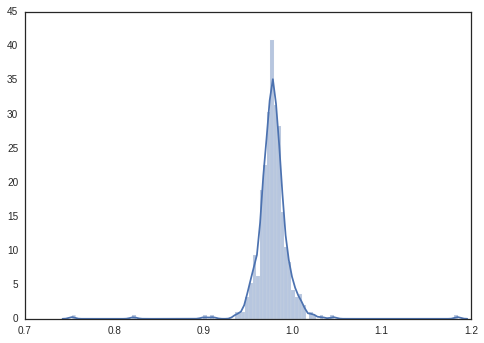

In [23]:
tickers = index('SP500') >> select(lambda x: x['Code'])
%time montecarlo(snp500_model, symbol=tickers, column=['Close']) \
>> select(lambda x: x.fitness) \
>> hist

...and here are the results. The strategy is a money loser (remember, the definition of profitable is fitness > 1). There is one single outlier giving a reasonable 18% gain, but for about 95% of cases the strategy loses money. The mean of the distributions is around fitness=0.98.

What if we use a split adjusted close price instead, should we expect any changes?

exception on shock={'column': 'Adj. Close', 'symbol': 'ACT', 'seq': 5}
exception on shock={'column': 'Adj. Close', 'symbol': 'BRK-B', 'seq': 64}
exception on shock={'column': 'Adj. Close', 'symbol': 'BF-B', 'seq': 74}
CPU times: user 9.63 s, sys: 860 ms, total: 10.5 s
Wall time: 17.7 s


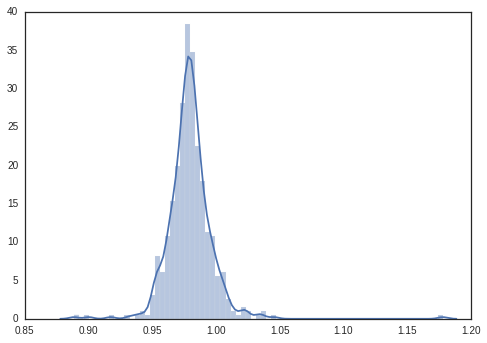

In [24]:
tickers = index('SP500') >> select(lambda x: x['Ticker'])
%time montecarlo(snp500_model, symbol=tickers, column=['Adj. Close']) \
>> select(lambda x: x.fitness) \
>> hist

Basically no changes. The strategy is still a money loser.

## Conclusion

We can draw a few conclusions from this exercise:

1. It is really easy to define hyphothesis and adjust models to rely on new features and methods of testing.
1. Everything is a contribution (evidence) - it should be very easy for any other researcher to replicate the steps on this experiment and prove the results right, or prove them wrong.

## Ok... What About the Performance of Momentum Strategies?

From what evidences show, the strategy is clearly not profitable and the hypothesis we had outlined on the beginning of this exercise is false.

However, there are strong discrepancies between what this little exercise shows and what several what several traders claim of 3 digits gains. There are several explanations I can think of.

1. Survivorship biases. There are scientific working papers pointing to trader's biases when reporting or tracking gains.
1. Traders might be using variations of this momentum strategy that are actually profitable, and not disclosing it
1. Either the data or algorithms we relied on is wrong or have bugs. The good news are they are all available and are verifiable.

## Final Notes

This framework is under work. Over the last few years it has been the subject of a doctorate research. If you are interested on more details you should refer to working papers we have released on the subject. 

A few of the features presented in here are adjusted to this specific scenario and are not entirely functional at this time. However they do align themselves with the vision of the long term research and should be used as an illustration of the roadmap.

This framework relies on dozens of open source libraries and resources, either used directly or adapted. Each of those dependencies might rely on several more, and the chain of dependencies are ever changing. It would be impossible to accurately list all of them.

We acknowledge a brief list:

* python https://www.python.org/
* cython http://cython.org/
* pandas http://pandas.pydata.org/
* iPython http://ipython.org/
* iPython notebook http://ipython.org/notebook.html
* numpy http://www.numpy.org/
* scipy http://www.scipy.org/
* matplotlib http://matplotlib.org/
* seaborn http://stanford.edu/~mwaskom/software/seaborn/
* pipes https://github.com/JulienPalard/Pipe
